In [32]:
import os
from configs.parser import YAMLParser
import mlflow
from dataloader.h5 import H5Loader
import torch
import numpy as np
from added_codes.funcs import visualize_flow
from added_codes.classes import AEE_HIST

import matplotlib.pyplot as plt

from loss.flow import FWL, RSAT, AEE
from utils.utils import load_model
from models.model import (
    FireNet,
    RNNFireNet,
    LeakyFireNet,
    FireFlowNet,
    LeakyFireFlowNet,
    E2VID,
    EVFlowNet,
    RecEVFlowNet,
    LeakyRecEVFlowNet,
    RNNRecEVFlowNet,
)

In [19]:
runid = "EVFlowNet"

mlflow.set_tracking_uri("")
run = mlflow.get_run(runid)
config_parser = YAMLParser("configs/eval_MVSEC.yml")
config = config_parser.config
config = config_parser.merge_configs(run.data.params)


In [20]:
data = H5Loader(config, config["model"]["num_bins"])
dataloader = torch.utils.data.DataLoader(
        data,
        drop_last=True,
        batch_size=config["loader"]["batch_size"],
        collate_fn=data.custom_collate,
        worker_init_fn=config_parser.worker_init_fn
    )

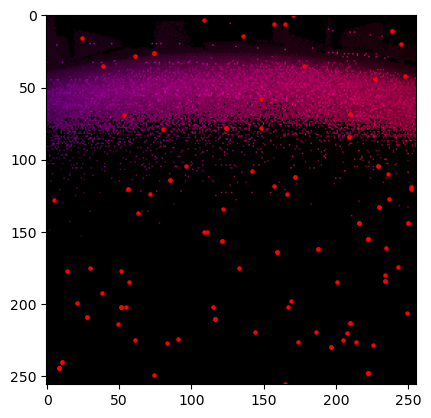

In [5]:
data_number = 0
flow = data[data_number]["gtflow"]


plt.imshow(visualize_flow(flow))
for ev in data[data_number]["event_list"].transpose(1, 0):
    plt.scatter(ev[1], ev[2], s=5, c="r")
plt.show()

In [33]:
import h5py
h5_file = h5py.File("datasets/data/MVSEC/h5/indoor_flying1_data.h5", "r")
print(h5_file.keys())


<KeysViewHDF5 ['events', 'flow', 'flow_dt1', 'flow_dt4', 'images']>


In [57]:
for flow_type in h5_file.keys():
    if flow_type == "events":
        continue
    list_ = [key for key in h5_file[flow_type].keys()]
    timestamps_list = [h5_file[flow_type+'/'+l].attrs["timestamp"] for l in list_]
    timestamps = np.array(timestamps_list)
    print(flow_type, 1/np.mean(np.diff(timestamps)), np.mean(np.diff(timestamps)),np.std(np.diff(timestamps)))

flow 19.997165478675445 0.050007087307767636 5.831633651593308e-05
flow_dt1 31.387945034346522 0.031859365081267396 4.923732455482245e-07
flow_dt4 7.846986227182647 0.1274374608350799 5.332144190399305e-07
images 31.387945096898132 0.031859365017776316 4.924776021160936e-07


The frame rate of the optical flow ground truth is 20 fps.

And the frame rate of the (grey scale) images is about 31 fps.

The ground truth is interpolated for 'flow_dt1' in the rate of image fps, i.e. 31 fps.

The ground truth for 'flow_dt4' is 1/4 of the 'flow_dt1'.

In [ ]:
import torch
import numpy as np
import os
import cv2


class DSectDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load the list of event and image files
        self.event_files = os.listdir(os.path.join(root_dir, "events"))
        self.image_files = os.listdir(os.path.join(root_dir, "images"))

        # Sort the files to ensure they match up
        self.event_files.sort()
        self.image_files.sort()

    def __len__(self):
        return len(self.event_files)

    def __getitem__(self, idx):
        # Load the event and image files for the given index
        event_file = os.path.join(self.root_dir, "events", self.event_files[idx])
        image_file = os.path.join(self.root_dir, "images", self.image_files[idx])

        # Load the event data
        events = np.load(event_file)

        # Load the image data
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

        # Apply transformations to the data if provided
        if self.transform:
            events, image = self.transform((events, image))

        # Convert the data to PyTorch tensors
        events = torch.from_numpy(events).float()
        image = torch.from_numpy(image).float()

        return events, image

In [ ]:
# Create the dataset
dataset = DSectDataset(root_dir='/path/to/dataset')

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Loop over the dataloader
for events, image in dataloader:
    # Do something with the event and image data
    pass
